# 6.6 Sourcing & Analyzing Time-Series Data

## Step 2
#### DataSource:
Used data from the website FRED, a trusted source of economic data since 1991. I specifically used the Retail Sales data set: https://fred.stlouisfed.org/series/MRTSSM44000USS. Here it details the observation data of retail sales by millions of dollars.

## Importing Libraries and Data 

In [2]:
#Imported Libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
#Imported path
path = r'/Users/racheldurand/Desktop/Data Analytics/Achievement 6'

In [4]:
path

'/Users/racheldurand/Desktop/Data Analytics/Achievement 6'

In [5]:
#Imported Adidas US Sales Dataset.csv
df = pd.read_csv(os.path.join(path, 'Prepared Data', 'TimeSeriesAnalysis.csv'), index_col = False)

## Data Cleaning

In [6]:
#Checked head
df.head()

,observation_date,MRTSSM44000USS
0,1/1/1992,146925
1,2/1/1992,147223
2,3/1/1992,146805
3,4/1/1992,148032
4,5/1/1992,149010


In [7]:
#Renamed the column
df = df.rename(columns={'MRTSSM44000USS': 'Millions of Dollars'})

In [8]:
df.columns

Index(['observation_date', 'Millions of Dollars'], dtype='object')

In [9]:
#Checked shape
df.shape

(379, 2)

In [10]:
#Checked for duplicates
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
374    False
375    False
376    False
377    False
378    False
Length: 379, dtype: bool

In [11]:
#Checked for missing values 
df.isnull().sum()

observation_date       0
Millions of Dollars    0
dtype: int64

In [12]:
#Converted the "observation_date" column to a datetime data type:
df['observation_date'] = pd.to_datetime(df['observation_date'])

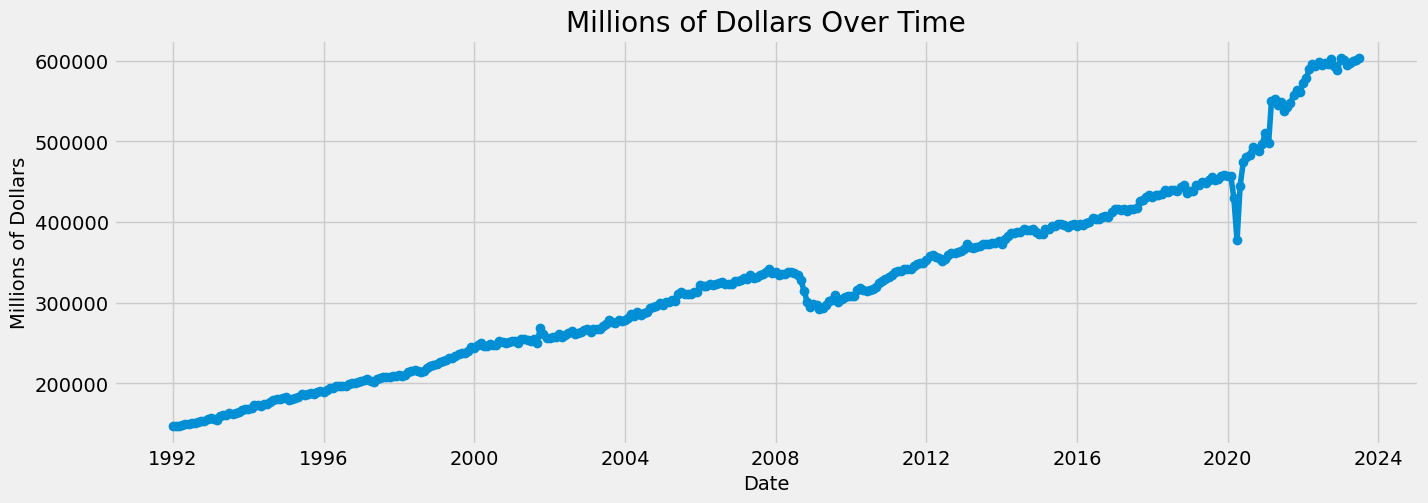

In [13]:
#Created a line plot using matplotlib:
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df['observation_date'], df['Millions of Dollars'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Millions of Dollars')
plt.title('Millions of Dollars Over Time')
plt.grid(True)
plt.show()

## Step 3
## Data Wrangling and Subsetting

In [14]:
#Created a subset
df_sub = df.loc[(df['observation_date'] >= '1/1/2000') & (df['observation_date'] < '7/1/2023')]

#### Why I Subsetted the Data:
I subsetted the data to begin from the 2000's to 2023 so we can have recent data relevant to this time period, as well as to stay consistent with my Adidas data set where the data is only in the 2000's.

In [15]:
#Rechecked shape
df_sub.shape

(282, 2)

In [16]:
#Rechecked head
df_sub.head()

,observation_date,Millions of Dollars
96,2000-01-01,243436
97,2000-02-01,247133
98,2000-03-01,249825
99,2000-04-01,245831
100,2000-05-01,246201


In [17]:
# Set the "Date" column as the index
df_sub = df_sub.set_index('observation_date') # Set the datetime as the index of the dataframe.
df_sub.head()

,Millions of Dollars
observation_date,
2000-01-01,243436
2000-02-01,247133
2000-03-01,249825
2000-04-01,245831
2000-05-01,246201


## Step 4 
## Line Chart of Data

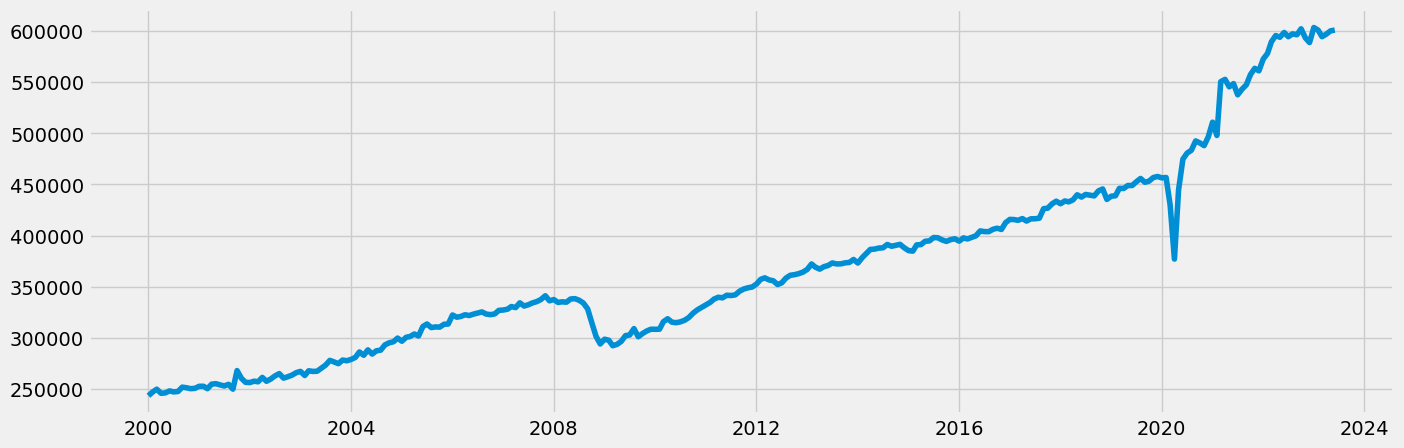

In [18]:
# Plotted the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [19]:
#Checked for missing values (you shouldn't have any)
df_sub.isnull().sum() 

Millions of Dollars    0
dtype: int64

In [20]:
#Checked for duplicates
dups = df_sub.duplicated()
dups.sum()
# No dups!

0

## Step 5
## Time-series analysis: decomposition

In [21]:
#Decomposed the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [22]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

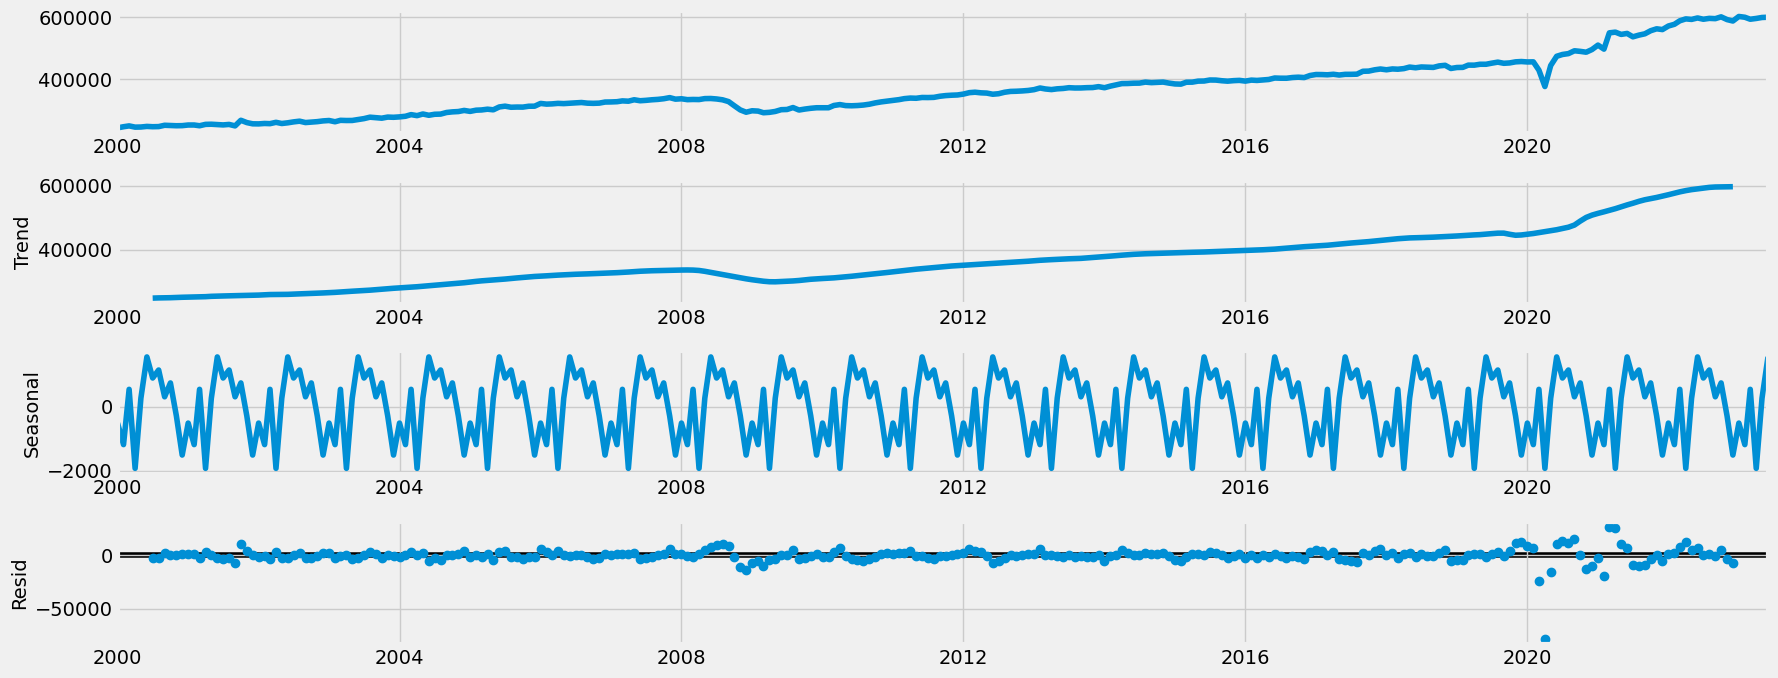

In [23]:
# Plot the separate components
decomposition.plot()
plt.show()

#### Observations
* Trend: There is a positive upward trend with dips around the years 2009 and 2020.
* Seasonality: Seasonality is present and observed by spiked curves that change at a regular interval.
* Noise: As seen in the residual line plot, there is little noise.
I would say this data is non-stationary as observed by the decomposition plot not remaining constant.

## Step 6
## Testing for stationarity

In [24]:
#Imported adfuller function
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Millions of Dollars'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.027007
p-value                          0.994543
Number of Lags Used             11.000000
Number of Observations Used    270.000000
Critical Value (1%)             -3.454804
Critical Value (5%)             -2.872305
Critical Value (10%)            -2.572506
dtype: float64


#### Observations
* The null hypothesis is that we are trying to disprove the presence of a unit root. This means the data would be stationary.
* The alternative hypothesis is that there is a unit root. This means that the data would be non-stationary. 

The critical value of -2.87 is a lot smaller than the test statistic of 1.03, which means that I can't reject the null hypothesis.

Therfore there is a unit root and the data is non-stationary so we need to stationary the data.

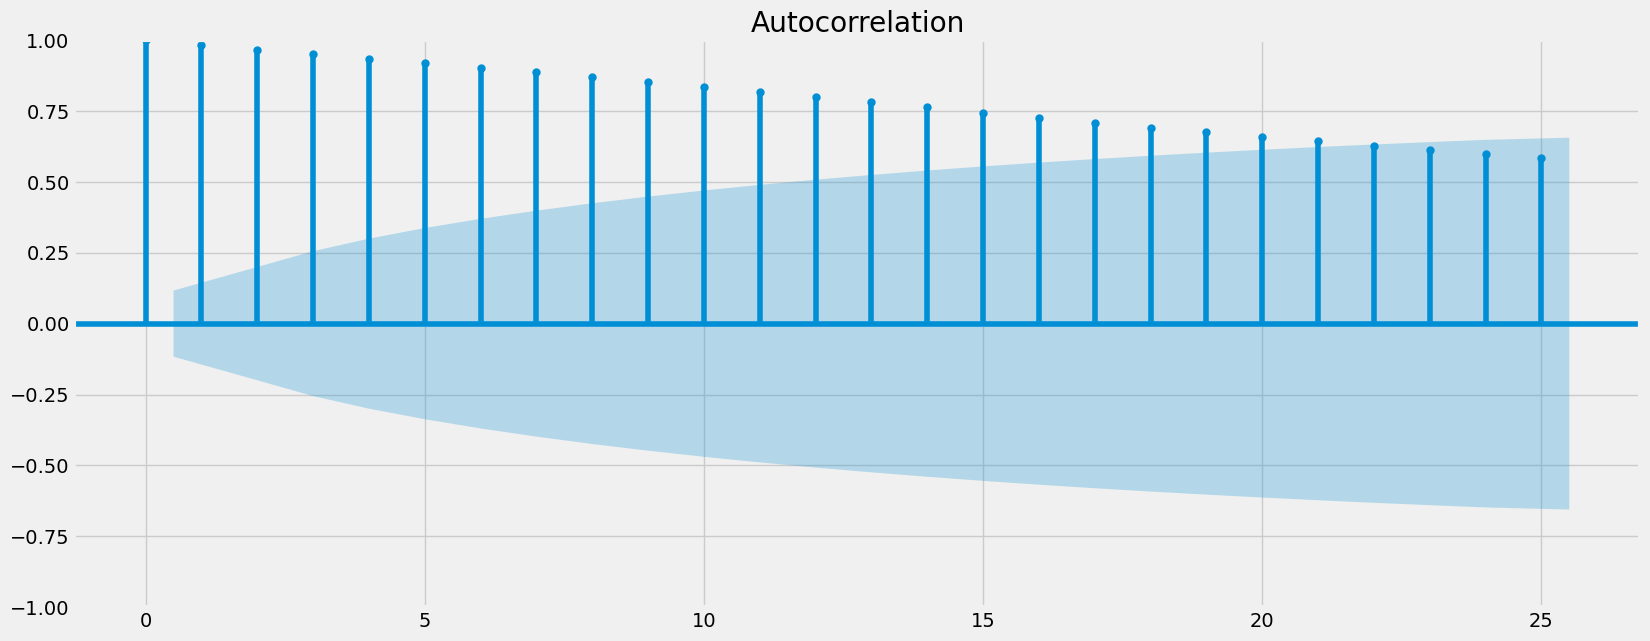

In [25]:
#Checked out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(df_sub)
plt.show()

#### Observations
There are many lags in the correlation plot as seen by the vertical lines being above the blue confidence level, showing that these lags are significantly correlated with each other.

## Step 7-8 Round of Differencing
## Stationarizing the Federal Reserve Economic Data

In [26]:
df_diff = df_sub - df_sub.shift(1) 

In [27]:
#Removed missing values from result of the differencing
df_diff.dropna(inplace = True)

In [28]:
#Checked head
df_diff.head()

,Millions of Dollars
observation_date,
2000-02-01,3697.0
2000-03-01,2692.0
2000-04-01,-3994.0
2000-05-01,370.0
2000-06-01,1959.0


In [29]:
df_diff.columns

Index(['Millions of Dollars'], dtype='object')

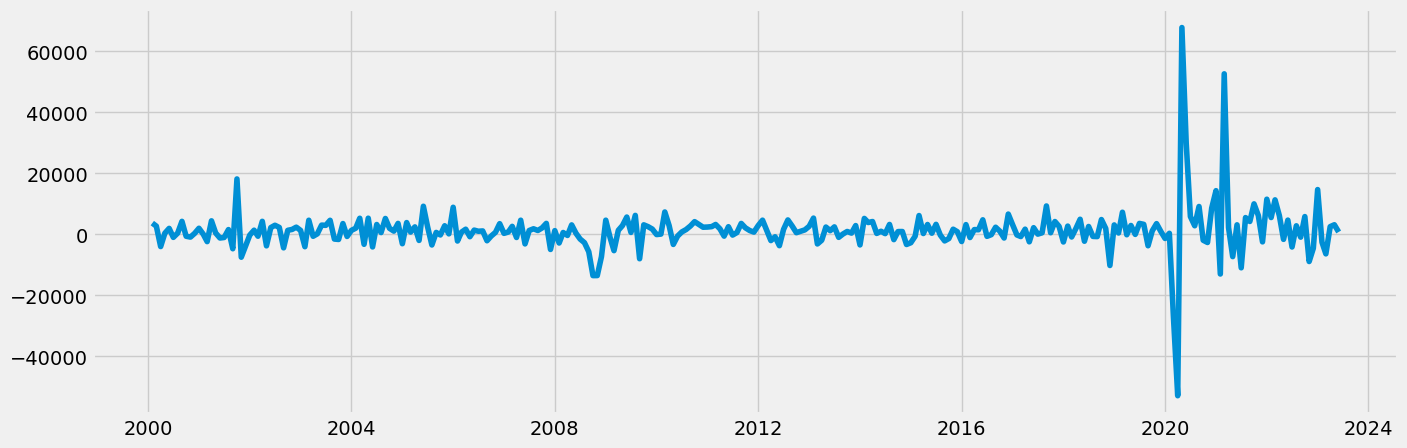

In [30]:
#Checked out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [31]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.034239
p-value                          0.001241
Number of Lags Used             10.000000
Number of Observations Used    270.000000
Critical Value (1%)             -3.454804
Critical Value (5%)             -2.872305
Critical Value (10%)            -2.572506
dtype: float64


#### Observations
Here the test statistic is now smaller than the 5% confidence level showcasing that the data is now stationary.

## Step 9
## Checked Data Autocorrelations

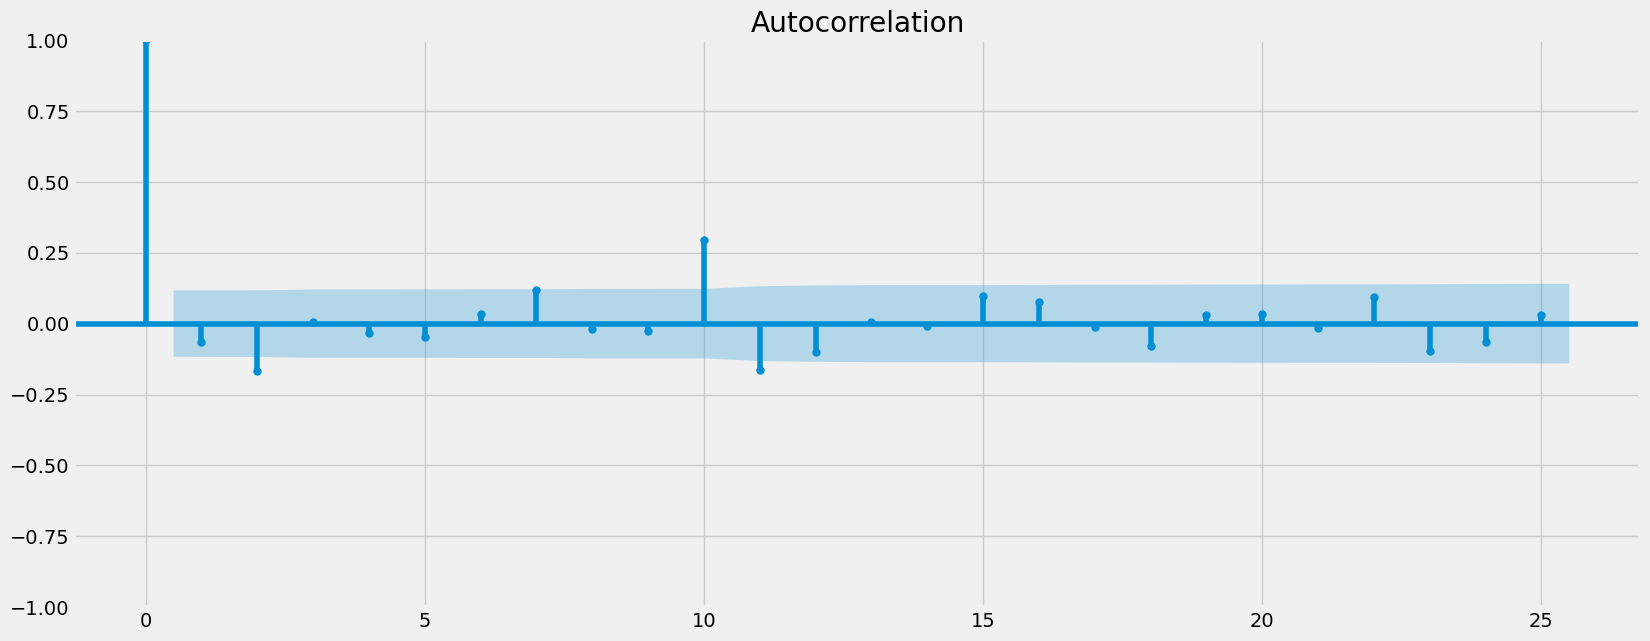

In [32]:
plot_acf(df_diff)
plt.show()

#### Observations
As displayed above the autocorrelation plot shows fewer lags showcasing that the data is stationary. 